In [2]:
import svgpathtools
from svgpathtools import Line, Path, svg2paths, wsvg, disvg
import numpy as np
import matplotlib.pyplot as plt
import math
import cvxpy as cp
import scipy
import scipy.ndimage

plt.style.use('seaborn')

# Parameters

In [12]:
# SEGMENT_LENGTH = 0.05  # in meters
SEGMENT_LENGTH = 0.05
TRACK_WIDTH = 1.3
ROBOT_HALF_WIDTH = 0.17 # includes safety padding
G = 9.807

ROBOT_MASS = 1.457 # kg
ROBOT_LF = 0.128
ROBOT_LR = 0.137
ROBOT_I = 0.0965

MIU = 0.8
TOP_SPEED = 11

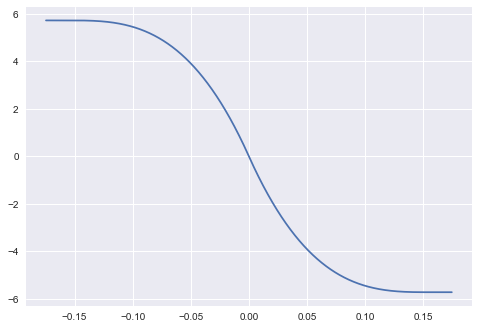

In [4]:
def fiala_tire_model(Fz, miu, C):
  alpha = []
  force = []

  thres = math.atan(3*miu*Fz/C)
  alpha = np.linspace(np.radians(-10), np.radians(10), 2000)
  for a in alpha:
    if abs(a) < thres:
      tan_a = math.tan(a)
      force.append(-C*tan_a + C**2*abs(tan_a)*tan_a/(3*miu*Fz) - C**3 * (tan_a**3) / (27*miu**2*Fz**2))
    else:
      force.append(-miu*Fz*np.sign(a))

  return alpha, force

Fz = ROBOT_MASS*G/2
C = MIU*Fz / np.radians(3)  # semi nonsense value.
alpha, force = fiala_tire_model(Fz, MIU, C)

plt.figure()
plt.plot(alpha, force)
plt.show()

# Returns alpha_hat, C_hat
def fiala_lookup(alpha, force, F):
  idx = np.searchsorted(force, F, sorter=np.arange(len(force)-1, -1, -1))
  idx = len(force) - 1 - idx
  if idx >= len(force) - 2:
    idx = len(force)-2
  elif idx < 0:
    idx = 0
  return alpha[idx], -(force[idx+1] - force[idx]) / (alpha[idx+1] - alpha[idx])

# Create Initial Offset

In [110]:
# construct offset curves for track boundaries

paths, attrs = svg2paths(r'c:\tmp\car\track2.svg')
path = paths[0]

def offset_curve(path, offset_distance, steps=1000):
    """Takes in a Path object, `path`, and a distance,
    `offset_distance`, and outputs an piecewise-linear approximation 
    of the 'parallel' offset curve."""
    nls = []
    for seg in path:
        for k in range(steps):
            t = k / steps
            offset_vector = offset_distance * seg.normal(t)
            nl = Line(seg.point(t), seg.point(t) + offset_vector)
            nls.append(nl)
    connect_the_dots = [Line(nls[k].end, nls[k+1].end) for k in range(len(nls)-1)]
    if path.isclosed():
        connect_the_dots.append(Line(nls[-1].end, nls[0].end))
    offset_path = Path(*connect_the_dots)
    return offset_path

left_boundary = offset_curve(path, 650.0, steps=5)
right_boundary = offset_curve(path, -650.0, steps=5)

disvg([path, left_boundary, right_boundary], 'brg', filename=r'c:\tmp\test_boundaries.svg')


# Optimize

In [5]:
paths, attrs = svg2paths(r'c:\tmp\test_out.svg')
racing_path = paths[0]
left_boundary = paths[1]
right_boundary = paths[2]

disvg([racing_path, left_boundary, right_boundary], 'brg', filename=r'c:\tmp\test.svg')

In [6]:
L = racing_path.length()
steps = int(L / (SEGMENT_LENGTH * 1000))
print("Path length is ", L)
tpts = [racing_path.ilength(L*k/steps) for k in range(steps)]
tpts[0] = 1e-8
pts = [racing_path.point(t) / 1000 for t in tpts]

Path length is  42100.871066661566


In [7]:
# create normal lines to find track widths
def create_normal(p, t, left):
  n = p.normal(t)
  if not left:
    n = -n
  return Line(p.point(t), p.point(t) + n * 10*TRACK_WIDTH*1000)

left_normals = Path()
right_normals = Path()
for t in tpts:
  left_normals.append(create_normal(racing_path, t, left=True))
  right_normals.append(create_normal(racing_path, t, left=False))

In [8]:
def find_boundary_dist(boundary, normals):
  intersections = []
  dists = []
  for nseg in normals:
    ts = []
    for (T1, seg, t1), (T2, seg2, t2) in boundary.intersect(nseg):
      ts.append(t2)
    min_t = min(ts) if ts else 1.0
    intersections.append(nseg.point(min_t))
    dists.append(nseg.length(0, min_t) / 1000)
  return dists, intersections

left_dists, left_intersections = find_boundary_dist(left_boundary, left_normals)
right_dists, right_intersections = find_boundary_dist(right_boundary, right_normals)

intersections = left_intersections + right_intersections

In [125]:
disvg([racing_path, left_boundary, right_boundary, left_normals, right_normals], 'brgoo', nodes=intersections, filename=r'c:\tmp\test.svg')

## Velocity

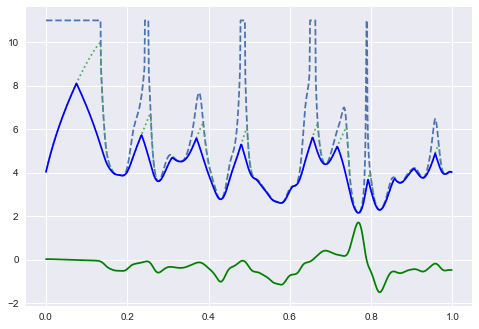

In [9]:
V = []
K = []
S = []

# path.curvature doesn't return sign!
def curvature(p, t):
  dz = p.derivative(t)
  ddz = p.derivative(t, n=2)
  dx, dy = dz.real, dz.imag
  ddx, ddy = ddz.real, ddz.imag
  return dx*ddy - dy*ddx/math.sqrt(dx*dx + dy*dy)**3

for t in tpts:
  # SVG y-axis is flipped
  Ks = -curvature(racing_path, t) * 1000
  K.append(Ks)
  S.append(racing_path.length(0, t) / 1000)

K = np.array(K) # hello! kitty loves bear
K = scipy.ndimage.gaussian_filter(K, sigma=7, mode='reflect')

for Ks in K:
  Vs = TOP_SPEED
  if abs(Ks) > 0.1:
    Vs = min(TOP_SPEED, math.sqrt(MIU*G/abs(Ks)))
  V.append(Vs)

plt.figure()
plt.plot(tpts, V, '--')

def max_a(v, k):
  f_residual = (MIU*G)**2 - (v**2*k)**2
  if f_residual > 0:
    return math.sqrt(f_residual)
  return 0.0

# TODO: fix used of SEGMENT length to s
for idx in range(len(V)):
  prev_idx = idx - 1 if idx > 0 else len(V) - 1
  prev_v = V[prev_idx]
  prev_k = K[prev_idx]
  a = max_a(prev_v, prev_k)
  force_constrained = math.sqrt(prev_v**2 + 2*a*SEGMENT_LENGTH)
  V[idx] = min(V[idx], force_constrained)

plt.plot(tpts, V, ':')

for idx in range(len(V)-1, -1, -1):
  next_idx = idx + 1 if idx + 1 < len(V) else 0
  next_v = V[next_idx]
  next_k = K[next_idx]
  a = max_a(next_v, next_k)
  force_constrained = math.sqrt(next_v**2 + 2*a*SEGMENT_LENGTH)
  V[idx] = min(V[idx], force_constrained)

S = np.array(S)

plt.plot(tpts, V, '-b')

plt.plot(tpts, K, 'g')
plt.show()

## Path

In [25]:
def c2d(dt, A, B, D):
  ar, ac = A.shape
  assert B.shape == (ar,1)
  assert D.shape == (ar,1)
  X = dt * np.concatenate((A, B, D), axis=1)
  r, c = X.shape
  X = np.concatenate((X, np.zeros((c-r, c))))
  Xt = scipy.linalg.expm(X)

  return Xt[0:ar,0:ac], Xt[0:ar,ac], Xt[0:ar,ac+1]

  

N = len(V)
x = cp.Variable((5, N)) # [e delta_heading yaw_rate beta heading]
# slack = cp.Variable(5)
delta = cp.Variable(N)
constraints = [
  x[0,0] == 0,
  x[0,:] <= left_dists,
  -1.0*x[0,:] <= right_dists,
  cp.abs(x[:,0] - x[0,-1]) <= 0.0001,
  # cp.abs(x[0,0] - x[0,-1]) <= 0.0001,
  # x[1:5,0] == x[1:5,-1]
]

for idx in range(N-1):
  dt = (S[idx+1]-S[idx])/V[idx]
  A = np.zeros((5, 5), dtype=np.float64)
  # assumes even weight dstro.. should fix?
  Fyf = ROBOT_MASS/2*K[idx]*V[idx]**2
  Fyr = Fyf
  slip_front, Cf = fiala_lookup(alpha, force, Fyf)
  slip_rear, Cr = fiala_lookup(alpha, force, Fyr)
  A[0,1] = V[idx]
  A[0,3] = V[idx]
  A[1,2] = 1.0
  A[2,2] = (-(ROBOT_LF**2)*Cf-(ROBOT_LR**2)*Cr)/(V[idx]*ROBOT_I)
  A[2,3] = (ROBOT_LR*Cr-ROBOT_LF*Cf)/ROBOT_I
  A[3,2] = (ROBOT_LR*Cr-ROBOT_LF*Cf)/(ROBOT_MASS*V[idx]**2) - 1
  A[3,3] = (-Cf-Cr)/(ROBOT_MASS*V[idx])
  A[4,2] = 1.0
  B = np.array([0.0, 0.0, ROBOT_LF * Cf / ROBOT_I, Cf / (ROBOT_MASS * V[idx]), 0]).reshape((5,1))
  D = np.array([
    0.0,
    -K[idx]*V[idx],
    (ROBOT_LF*Cf*slip_front - ROBOT_LR*Cr*slip_rear + ROBOT_LF*Fyf - ROBOT_LR*Fyr)/ROBOT_I,
    (Cf*slip_front + Cr*slip_rear + Fyf + Fyr)/(ROBOT_MASS*V[idx]),
    0.0
  ]).reshape((5,1))
  Ak, Bk, Dk = c2d(dt, A,B,D)
  constraints.append(x[:,idx+1] == Ak@x[:,idx] + Bk*delta[idx] + Dk)

# obj = cp.Minimize(cp.sum_squares(cp.diff(x[4,:])/np.diff(S)) + 0.01*cp.sum_squares(cp.diff(delta)) + 500000*cp.norm(slack, p=2))
obj = cp.Minimize(cp.sum_squares(cp.diff(x[4,:])/np.diff(S)) + 1.0*cp.sum_squares(cp.diff(delta)))

prob = cp.Problem(obj, constraints)
prob.solve()

print("status:", prob.status)
print("optimal value", prob.value)

status: optimal
optimal value 166.74302059697047


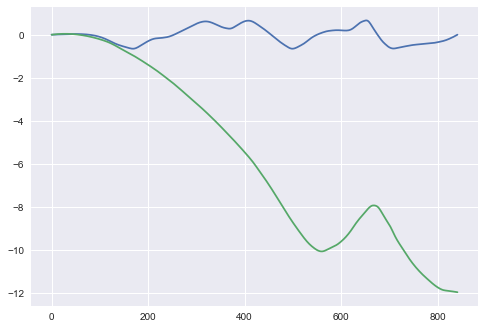

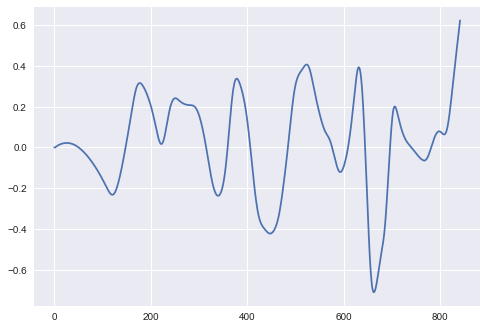

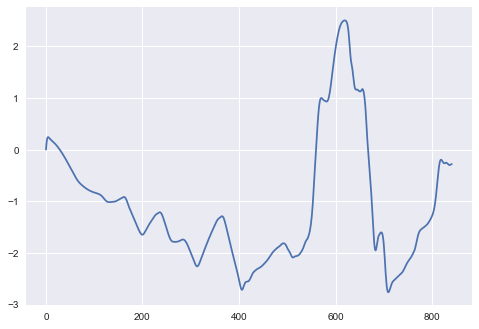

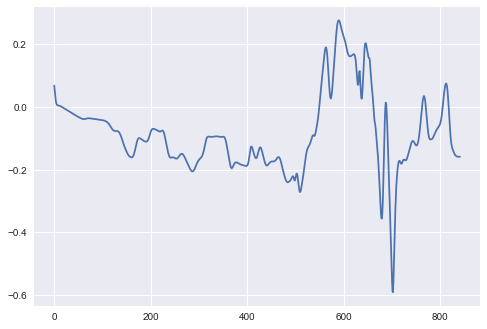

In [26]:
plt.figure()
xaxis = [x for x in range(842)]
plt.plot(xaxis, x.value[0,:], xaxis, x.value[4,:])
plt.show()
plt.figure()
plt.plot(xaxis, x.value[1,:])
plt.show()
plt.figure()
plt.plot(xaxis, x.value[2,:])
plt.show()
plt.figure()
plt.plot(xaxis, delta.value)
plt.show()

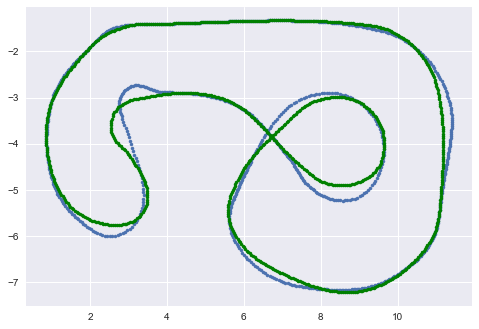

In [27]:
plt.figure()

xs = []
ys = []
for idx in range(len(pts)):
  xp, yp = pts[idx].real, -pts[idx].imag
  xstar = x.value[:,idx]
  xs.append(xp - xstar[0]*math.cos(xstar[4]))
  ys.append(yp - xstar[0]*math.sin(xstar[4]))
plt.plot(xs,ys,'.')

xs = [p.real for p in pts]
ys = [-p.imag for p in pts]
plt.plot(xs,ys,'.g')
plt.show()

In [169]:
print(x.value[:,0])
print(x.value[:,-1])
print(slack.value)
print(min(left_dists), min(right_dists))

[-3.49157535e-13 -5.28480841e-02 -2.73161389e-01 -1.50426633e-10
 -1.34967444e-10]
[-1.34950799e-10  1.70649630e+00 -5.17678344e+00 -5.04746702e+00
 -1.08057618e+01]
[1.03462569e-17 5.28480838e-02 2.73161389e-01 5.67837775e-19
 1.75438537e-20]
0.19144465395475613 0.12361670239671484
